In [1]:
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("../data/user_detail.csv")
df.review = df.review.apply(lambda x: x.replace("\r", " "))
df=df[['score', 'review']]
df.score = df.score.apply(lambda x: 0 if x<6 else 1)

### train_test split

In [2]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

train, test = train_test_split(df)

In [3]:
def except_stopwords(words):
    stopWords = set(stopwords.words('english'))
    wordsFiltered = []
    for w in words:
        if w not in stopWords:
            wordsFiltered.append(w)
    return wordsFiltered

### tokenize + stopwords check

In [4]:
%%time
train.review = train.review.apply(lambda x: except_stopwords(word_tokenize(x)))
test.review = test.review.apply(lambda x: except_stopwords(word_tokenize(x)))

CPU times: user 4min 5s, sys: 2.62 s, total: 4min 7s
Wall time: 4min 7s


### pos tagging

In [5]:
from nltk.tag import pos_tag

def postagger(doc):
    return ["/".join(p) for p in pos_tag(doc)]

In [6]:
%%time
train_docs = [(postagger(row[1]), row[0]) for row in train.values]
test_docs = [(postagger(row[1]), row[0]) for row in test.values]

CPU times: user 13min 56s, sys: 2.03 s, total: 13min 58s
Wall time: 13min 59s


In [7]:
import pickle

with open('train_docs', 'wb') as f:
    pickle.dump(train_docs, f)
with open('test_docs', 'wb') as f:
    pickle.dump(test_docs, f)

In [8]:
with open('train_docs', 'rb') as f:
    train_docs = pickle.load(f)
with open('test_docs', 'rb') as f:
    test_docs = pickle.load(f)

---

In [9]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

8092745


In [11]:
import nltk
from pprint import pprint
text = nltk.Text(tokens, name='NMSC')

print(len(text.tokens))                 # returns number of tokens
print(len(set(text.tokens)))            # returns number of unique tokens
pprint(text.vocab().most_common(10))    # returns frequency distribution

8092745
274183
[('./.', 544662),
 (',/,', 483854),
 ('game/NN', 216562),
 ('I/PRP', 173198),
 ('The/DT', 87220),
 ("n't/RB", 63428),
 ("'s/POS", 60145),
 ('!/.', 48121),
 ('like/IN', 45301),
 (')/)', 42021)]


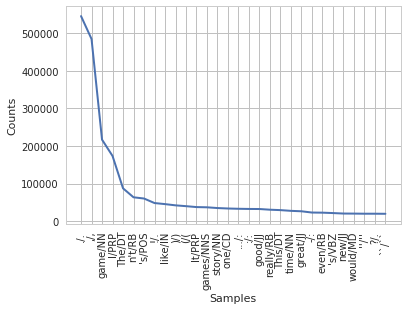

In [12]:
%matplotlib inline
text.plot(30)

---

### doc2vec

In [13]:
from collections import namedtuple

TaggedDocument = namedtuple('TaggedDocument', 'words tags')

tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [14]:
from gensim.models import doc2vec
# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, seed=0)
doc_vectorizer.build_vocab(tagged_train_docs)

In [15]:
doc_vectorizer.train(tagged_train_docs, total_words=200, epochs=10)

In [16]:
pprint(doc_vectorizer.wv.most_similar('super/VBP'))

[('pretty/VBP', 0.5168228149414062),
 ('sick/VBP', 0.45459121465682983),
 ('arent/VBP', 0.4333750307559967),
 ('bow/VBP', 0.4276562035083771),
 ('fight/VBP', 0.4271119236946106),
 ('jump/VBP', 0.42688852548599243),
 ('somewhat/VBP', 0.4178714454174042),
 ('drawn/VBP', 0.4176331162452698),
 ('breath/VBP', 0.41567105054855347),
 ('crazy/VBP', 0.41521716117858887)]


In [17]:
pprint(doc_vectorizer.wv.most_similar('unfortunately/RB'))

[('sadly/RB', 0.4954332113265991),
 ('thankfully/RB', 0.38715600967407227),
 ('ultimately/RB', 0.3534807860851288),
 ('annoying../RB', 0.3033813238143921),
 ('fun…/NN', 0.29176831245422363),
 ('quality/VBP', 0.2848546802997589),
 ('Unfortunately/RB', 0.284615695476532),
 ('Sadly/RB', 0.2832390069961548),
 ('there…/NN', 0.2786073088645935),
 ('marred/JJ', 0.27605366706848145)]


In [18]:
%%time
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
len(train_x)

CPU times: user 2min 59s, sys: 644 ms, total: 3min
Wall time: 3min


In [19]:
%%time
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]

CPU times: user 55.8 s, sys: 155 ms, total: 55.9 s
Wall time: 56 s


In [20]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)

0.8077303477469636

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import *

y_pred = classifier.predict(test_x)

print("acc:", accuracy_score(test_y, y_pred))
print(confusion_matrix(test_y, y_pred))

print(classification_report(test_y, y_pred))

acc: 0.8077303477469636
[[ 3319  3186]
 [ 1674 17098]]
             precision    recall  f1-score   support

          0       0.66      0.51      0.58      6505
          1       0.84      0.91      0.88     18772

avg / total       0.80      0.81      0.80     25277



Naive bayes와 비교
- doc2vec와는 궁합이 잘 안맞는가...

In [22]:
from sklearn.preprocessing import minmax_scale

train_x1 = minmax_scale(train_x)
test_x1 = minmax_scale(test_x)

from sklearn.naive_bayes import MultinomialNB 
MNB = MultinomialNB(alpha=0.5)
MNB.fit(train_x1, train_y)
MNB.score(test_x1, test_y)

0.7426514222415634

In [23]:
y_pred = MNB.predict(test_x)

print("acc:", accuracy_score(test_y, y_pred))
print(confusion_matrix(test_y, y_pred))

print(classification_report(test_y, y_pred))

acc: 0.7426514222415634
[[    0  6505]
 [    0 18772]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      6505
          1       0.74      1.00      0.85     18772

avg / total       0.55      0.74      0.63     25277



In [24]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
clf.fit(train_x, train_y)
clf.score(test_x, test_y)

0.7673774577679313

In [25]:
y_pred = clf.predict(test_x)

print("acc:", accuracy_score(test_y, y_pred))
print(confusion_matrix(test_y, y_pred))

print(classification_report(test_y, y_pred))

acc: 0.7673774577679313
[[ 4212  2293]
 [ 3587 15185]]
             precision    recall  f1-score   support

          0       0.54      0.65      0.59      6505
          1       0.87      0.81      0.84     18772

avg / total       0.78      0.77      0.77     25277



### todo
- gridsearch